# **Objective**
- This notebook explores the use of a **Transformer model** for **image captioning**.
- **Image captioning** combines **computer vision** and **natural language processing**.
- The goal is to generate **descriptive text from visual content** efficiently.
- This serves as a **step-by-step tutorial** on transformer models for **image captioning**.

### **What is a Transformer?**
- A **Transformer** is an advanced **deep learning architecture** for sequences.
- It is effective in **Natural Language Processing (NLP)** tasks like:
  - **Machine translation**
  - **Text summarization**
- Unlike **RNNs** and **LSTMs**, transformers:
  - Enable **parallelized training**
  - Improve **computational efficiency**
- Popular transformer models include:
  - **BERT** (Bidirectional Encoder Representations from Transformers)
  - **GPT** (Generative Pre-trained Transformer)
- Refer to **"Attention is All You Need"** by **Vaswani et al. (2017)** for details.




!pip install plotly
!pip install nltk
!pip install ipywidgets --upgrade

https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf



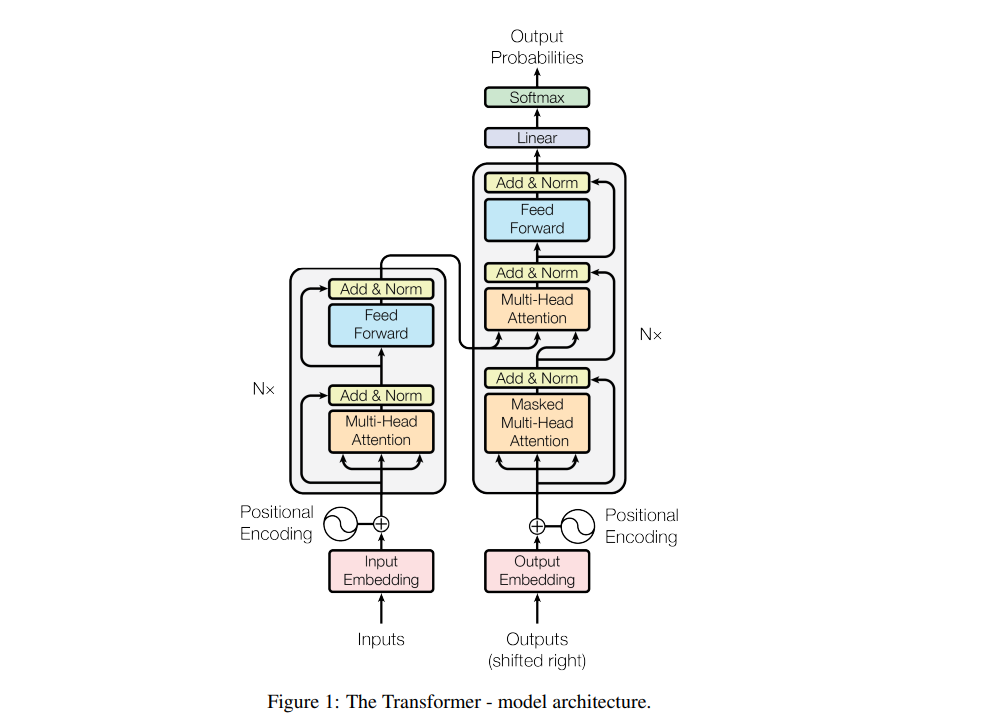

### **Terminology**
- **Input Embedding:**
  - Converts words into vector representations.
  - Captures **semantic relationships**.
- **Positional Encoding:**
  - Provides **sequence order information**.
  - It is **non-trainable**.
- **Multi-Head Attention:**
  - Focuses on different input sequence parts simultaneously.
- **Masking:**
  - Prevents attention to **future tokens and padding tokens**.
- **Multi-Head Cross-Attention:**
  - Allows the decoder to attend to **encoder outputs**.
  - Helps process **variable-length inputs**.

## **Methodology**
### **1. Data Collection and Pre-processing**
- The **Flickr30k** dataset is used for training the model.
- Pre-processing includes:
  - **Caption normalization**
  - **Length filtering**
  - **Dataset splitting** into train, test, and validation sets.
- Image processing involves:
  - **Decoding images**
  - **Resizing images** for consistency.
- TensorFlow functions optimize dataset processing:
  - **Shuffling**
  - **Mapping transformations**
  - **Batching**
  - **Prefetching**

### **2. Model Architecture**
- The model integrates a **pre-trained EfficientNetB0 CNN** for feature extraction.
- Extracted features undergo:
  - **Normalization**
  - Processing through **dense layers** to align with the encoder.
- **Encoder Components:**
  - Uses **multi-head attention** for contextual understanding.
  - Applies **layer normalization** to stabilize training.
- **Decoder Components:**
  - Receives **target captions** and **encoder outputs**.
  - Uses **positional embedding** for word order.
  - Applies **masked multi-head attention** to focus on words.
  - Uses **multi-head cross-attention** to align with encoder output.
  - Implements **feed-forward layers** for transformation.
  - The final output is a **Dense layer with softmax activation**.

### **3. Training Process**
- **Input for the encoder:**
  - Image features from **EfficientNetB0**.
- **Input for the decoder:**
  - Five **captions[:, :-1]** (excluding `<end>` token).
- **Target captions:**
  - Five **captions[:, 1:]** (excluding `<start>` token).
- **Training goal:**
  - Optimize **weights** for accuracy.
  - Minimize **loss function** using **backpropagation**.

### **4. Inference and Evaluation**
- **Loss Function:**
  - Uses **Sparse Categorical Crossentropy loss**.
- **Caption Generation:**
  - Uses a **Greedy algorithm** to generate captions.
- **Evaluation Metric:**
  - Measures accuracy using the **BLEU score**.

## Lets starts with library set up  

In [1]:
!pip install plotly
!pip install nltk
!pip install ipywidgets --upgrade


In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers import TextVectorization
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
from collections import Counter
from keras.saving import register_keras_serializable
from tensorflow.keras.layers import RandomRotation, RandomZoom



In [4]:
# Path to the images
IMAGES_PATH = "/kaggle/input/flickr8k/Images"
# Path to the captions
CAPTIONS_PATH = "/kaggle/input/flickr8k/captions.txt"
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 256
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Loads captions (text) data and maps them to corresponding images.

In [5]:

def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()[1:]
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Each image is repeated five times for the five different captions.
            # Image name and captions are separated using a comma
            img_name, caption = line.split(",", 1)
            img_name = os.path.join(IMAGES_PATH, img_name.strip())
            # Removing caption that are either too short to too long
            tokens = caption.strip().split()
            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # A start and an end token must be added to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

# Splits the dataset into training, validation, and test sets
def train_val_split(caption_data, validation_size=0.2, test_size=0.05, shuffle=True):
    # Getting the list of all image names
    all_images = list(caption_data.keys())
    
    # Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)
    
    train_keys, validation_keys = train_test_split(all_images, test_size=validation_size, random_state=42)
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)
    
    training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    validation_data = {img_name: caption_data[img_name] for img_name in validation_keys}
    test_data = {img_name: caption_data[img_name] for img_name in test_keys}

    # Return the splits
    return training_data, validation_data, test_data

# Loading the dataset
captions_mapping, text_data = load_captions_data(CAPTIONS_PATH)

# Spliting the dataset
train_data, validation_data, test_data = train_val_split(captions_mapping)
print(f"Total number of samples: {len(captions_mapping)}")
print(f"----> Number of training samples: {len(train_data)}")
print(f"----> Number of validation samples: {len(validation_data)}")
print(f"----> Number of test samples: {len(test_data)}")

Total number of samples: 7643
----> Number of training samples: 6114
----> Number of validation samples: 1452
----> Number of test samples: 77


## Defining the vectorizer with custom standardization and image augmentation

In [6]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
    # Lowercasing all of the captions
    lowercase = tf.strings.lower(input_string)
    # Charecters to remove
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~1234567890"
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Defining the vectorizer
vectorization = TextVectorization(
    # Number of unique tokens
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    # Maximum length of captions. Padding tokens(zeros) will be added to shorter captions.
    output_sequence_length=SEQ_LENGTH,
    # Standardizing the captions
    standardize=custom_standardization)

# Adapting the vectorizer with the captions
vectorization.adapt(text_data)


# Standardizing the text data
text_data = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1], text_data))

# Visualizing some of the data set images along with the corresponding captions

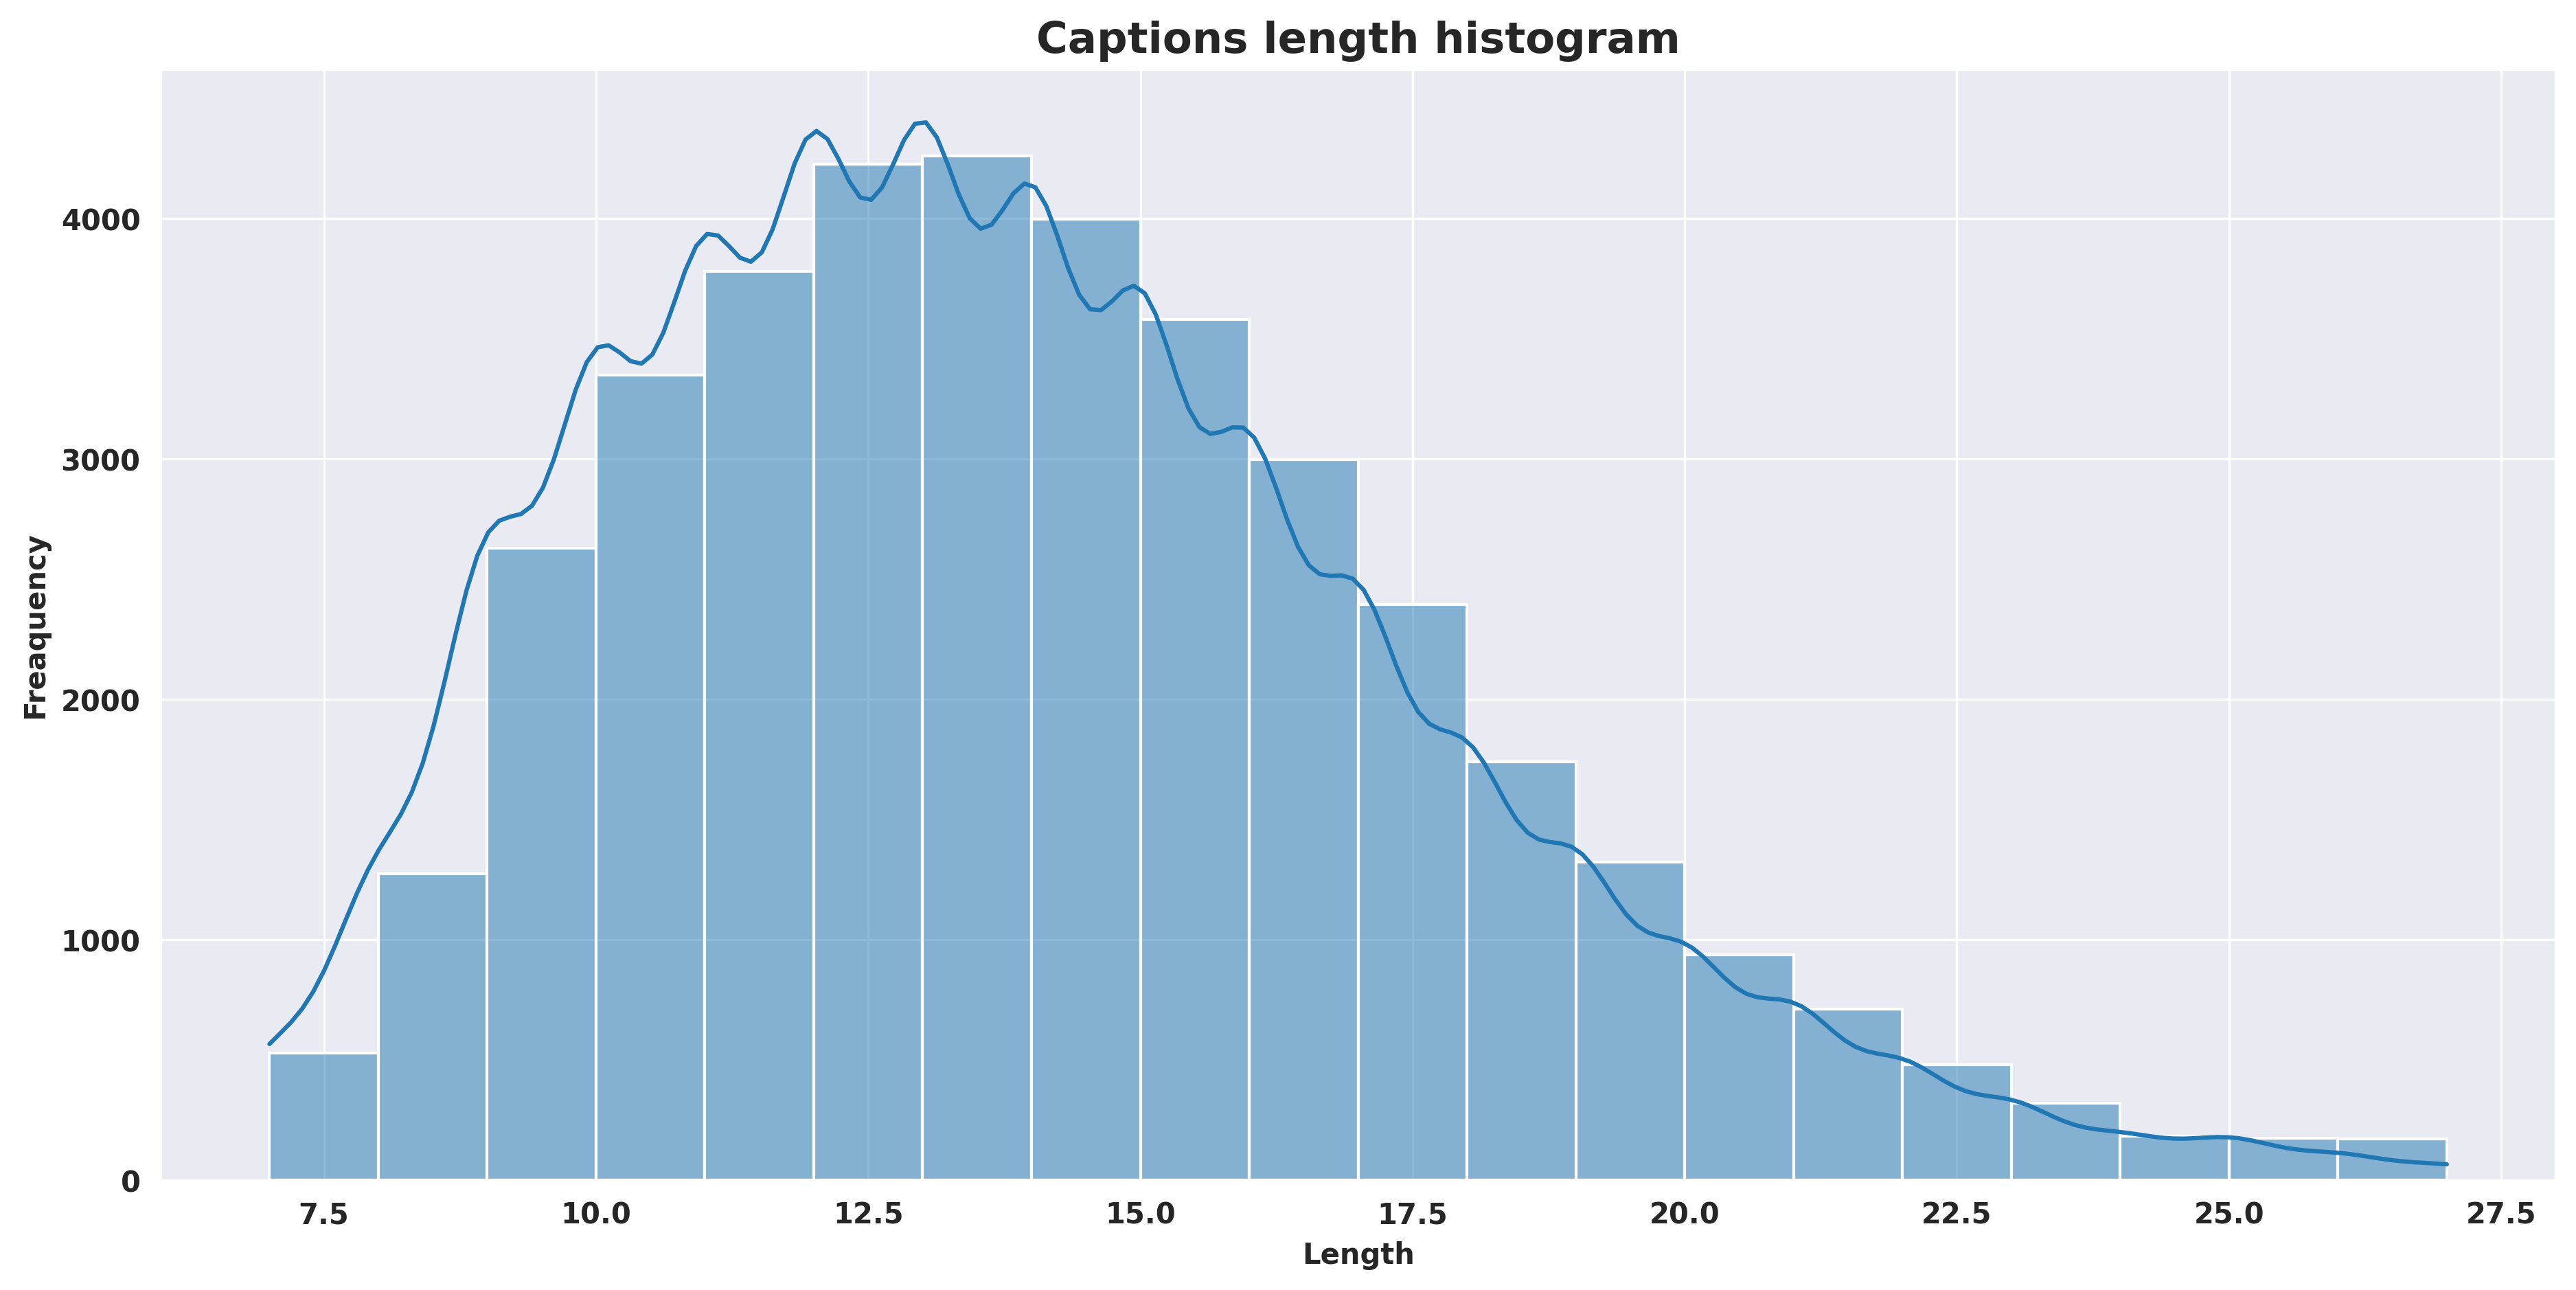

In [7]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(text_data)

In [8]:
def word_occurrences(data):
    # Combining all sentences into a single string
    all_text = ' '.join(data)
    all_text = all_text.replace('a ', '')
    all_text = all_text.replace('<start> ', '')
    all_text = all_text.replace('<end> ', '')
    # Splitting the text into words and count occurrences
    word_counts = Counter(all_text.split())

    words = list(word_counts.keys())[:30]
    values = list(word_counts.values())[:30]

    # Normalize values to be between 0 and 1
    normalized_values = np.array(values) / np.max(values)
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * (value)) for value in normalized_values])

    fig = go.Figure(data=[go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label')])

    fig.update_layout(title_text='Word occurrences in captions (except for letter \'a\')', title_font=dict(size=23, family='Balto'))

    fig.show()
    
word_occurrences(text_data)

# Data Setup for Model Input
## Parallelization Involves breaking down a task into smaller subtasks that can be executed in parallel.
## 'tf.data.AUTOTUNE' determines the optimal level of parallelism.

In [9]:
# Processes the images
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    # Processed images: (None, 299, 299, 3), Vectorized captions: (None, None, 25)
    return decode_and_resize(img_path), vectorization(captions)

# Prepares the dataset
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    # Prefetching the next batch of data based on available resources while the current batch is being processed.
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

# Making the datasets by passing the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
validation_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

In [10]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None))>

# Defining the Image Captioning Model

## CNN (Feature Extraction)
- **Pre-Trained Model:** EfficientNetB0

## Encoder (Embedded Image Features)
- **Layer Normalization Layer**
- **Dense Layer**
- **Multi-Head Attention Layer**
- **Layer Normalization Layer**

## Decoder (Embedded Captions)
- **Positional Embedding Layer** (input embedding + positional encoding)
- **Mask** (enables the model to ignore both padding tokens and future tokens)
- **Multi-Head Attention Layer**
- **Layer Normalization Layer**
- **Multi-Head Cross-Attention Layer**
- **Layer Normalization Layer**
- **Feed Forward Layer**
- **Layer Normalization Layer**

## Output
- **Dense Layer + Softmax Activation Function**


In [11]:
# Data augmentation for image data
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                       layers.RandomRotation(factor=0.2),
                                       layers.RandomContrast(0.3)])
def get_cnn_model():
	base_model = efficientnet.EfficientNetB0(
		input_shape=(*IMAGE_SIZE, 3),
		include_top=False,  # Removing the prediction layers
		weights="imagenet")
	# Freezing the model's weights
	base_model.trainable = False
	base_model_out = base_model.output
	base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
	cnn_model = keras.models.Model(base_model.input, base_model_out)
	return cnn_model

@tf.keras.utils.register_keras_serializable()
class TransformerEncoderBlock(layers.Layer):
	def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
		super().__init__(**kwargs)
		self.embed_dim = embed_dim
		self.dense_dim = dense_dim
		self.num_heads = num_heads
		self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.0)
		self.layernorm_1 = layers.LayerNormalization()
		self.layernorm_2 = layers.LayerNormalization()
		self.dense_1 = layers.Dense(embed_dim, activation="relu")
	
	def call(self, inputs, training, mask=None):
		inputs = self.layernorm_1(inputs)
		inputs = self.dense_1(inputs)
		attention_output_1 = self.attention_1(query=inputs,
											  value=inputs,
											  key=inputs,
											  attention_mask=None,
											  training=training)
		out_1 = self.layernorm_2(inputs + attention_output_1)
		return out_1

@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
	def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
		super().__init__(**kwargs)
		self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
		self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
		self.sequence_length = sequence_length
		self.vocab_size = vocab_size
		self.embed_dim = embed_dim
		self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))
	
	def call(self, inputs):
		length = tf.shape(inputs)[-1]
		positions = tf.range(start=0, limit=length, delta=1)  # Positional encoding
		embedded_tokens = self.token_embeddings(inputs)  # Input embedding
		embedded_tokens = embedded_tokens * self.embed_scale
		embedded_positions = self.position_embeddings(positions)
		return embedded_tokens + embedded_positions  # Positional embedding
	
	def compute_mask(self, inputs, mask=None):
		return tf.math.not_equal(inputs, 0)

@tf.keras.utils.register_keras_serializable()
class TransformerDecoderBlock(layers.Layer):
	def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
		super().__init__(**kwargs)
		self.embed_dim = embed_dim
		self.ff_dim = ff_dim
		self.num_heads = num_heads
		self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
		self.cross_attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
		self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
		self.ffn_layer_2 = layers.Dense(embed_dim)
		
		self.layernorm_1 = layers.LayerNormalization()
		self.layernorm_2 = layers.LayerNormalization()
		self.layernorm_3 = layers.LayerNormalization()
		
		self.embedding = PositionalEmbedding(embed_dim=EMBED_DIM,
											 sequence_length=SEQ_LENGTH,
											 vocab_size=VOCAB_SIZE, )
		self.out = layers.Dense(VOCAB_SIZE, activation="softmax")
		
		self.dropout_1 = layers.Dropout(0.3)
		self.dropout_2 = layers.Dropout(0.5)
		self.supports_masking = True
	
	def call(self, inputs, encoder_outputs, training, mask=None):
		inputs = self.embedding(inputs)
		causal_mask = self.get_causal_attention_mask(inputs)
		
		# If the mask is not None, it means that padding tokens are present in the input sequence.
		if mask is not None:
			padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
			combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
			# Masking both padding tokens and future tokens
			combined_mask = tf.minimum(combined_mask, causal_mask)
		
		attention_output_1 = self.attention_1(query=inputs,
											  value=inputs,
											  key=inputs,
											  attention_mask=combined_mask,
											  training=training)
		out_1 = self.layernorm_1(inputs + attention_output_1)
		
		# Note that the lengths of the inputs are different and cross-attention handles that.
		cross_attention_output_2 = self.cross_attention_2(query=out_1,
														  value=encoder_outputs,
														  key=encoder_outputs,
														  attention_mask=padding_mask,
														  training=training)
		out_2 = self.layernorm_2(out_1 + cross_attention_output_2)
		
		ffn_out = self.ffn_layer_1(out_2)
		ffn_out = self.dropout_1(ffn_out, training=training)
		ffn_out = self.ffn_layer_2(ffn_out)
		
		ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
		ffn_out = self.dropout_2(ffn_out, training=training)
		
		preds = self.out(ffn_out)
		return preds
	
	# Masks future tokens
	def get_causal_attention_mask(self, inputs):
		input_shape = tf.shape(inputs)
		batch_size, sequence_length = input_shape[0], input_shape[1]
		i = tf.range(sequence_length)[:, tf.newaxis]
		j = tf.range(sequence_length)
		mask = tf.cast(i >= j, dtype="int32")
		mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
		mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0)
		return tf.tile(mask, mult)

@tf.keras.utils.register_keras_serializable()
class ImageCaptioningModel(keras.Model):
	def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
		super().__init__()
		self.cnn_model = cnn_model
		self.encoder = encoder
		self.decoder = decoder
		self.loss_tracker = keras.metrics.Mean(name="loss")
		self.acc_tracker = keras.metrics.Mean(name="accuracy")
		self.num_captions_per_image = num_captions_per_image
		self.image_aug = image_aug
		
		print()
		print(f'CNN input shape: {cnn_model.input_shape}')
		print(f'CNN output shape: {cnn_model.output_shape}', end='\n' * 2)
		print(
			f'Encoder input ---> Dense layer shape: {cnn_model.output_shape} ---> (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
		print(f'Encoder output shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})', end='\n' * 2)
		print(
			f'Decoder input 1 (Caption) ---> Positional Embedding shape: (None, {SEQ_LENGTH - 1}) ---> (None, {SEQ_LENGTH - 1}, {EMBED_DIM})')
		print(f'Decoder input 2 (Embedded image features) shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
		print(f'Decoder output (MH Cross-Attention) shape: (None, {SEQ_LENGTH - 1}, {EMBED_DIM})')
		print(f'Decoder prediction (Dense layer) shape: (None, {SEQ_LENGTH - 1}, {VOCAB_SIZE})')
	
	# Calculates the loss, taking into account a mask to handle padding.
	def calculate_loss(self, y_true, y_pred, mask):
		loss = self.loss(y_true, y_pred)
		mask = tf.cast(mask, dtype=loss.dtype)
		loss *= mask
		return tf.reduce_sum(loss) / tf.reduce_sum(mask)
		
		
	@classmethod
	def from_config(cls, config):
		cnn_model = get_cnn_model()  # Load the pre-trained CNN model
		encoder = tf.keras.utils.deserialize_keras_object(config["encoder"])
		decoder = tf.keras.utils.deserialize_keras_object(config["decoder"])
		image_aug = tf.keras.utils.deserialize_keras_object(config["image_aug"]) if config["image_aug"] else None
		return cls(cnn_model=cnn_model, encoder=encoder, decoder=decoder,
				   num_captions_per_image=config["num_captions_per_image"], image_aug=image_aug)
	
	def get_config(self):
		config = super().get_config()
		config.update({
			"encoder": tf.keras.utils.serialize_keras_object(self.encoder),
			"decoder": tf.keras.utils.serialize_keras_object(self.decoder),
			"num_captions_per_image": self.num_captions_per_image,
			"image_aug": tf.keras.utils.serialize_keras_object(self.image_aug) if self.image_aug else None
		})
		return config
	
	# Calculates the accuracy, taking into account a mask to handle padding.
	def calculate_accuracy(self, y_true, y_pred, mask):
		accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
		accuracy = tf.math.logical_and(mask, accuracy)
		accuracy = tf.cast(accuracy, dtype=tf.float32)
		mask = tf.cast(mask, dtype=tf.float32)
		return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
	
	def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
		encoder_out = self.encoder(img_embed, training=training)
		batch_seq_inp = batch_seq[:, :-1]
		batch_seq_true = batch_seq[:, 1:]
		# Creating a binary mask where 1 indicates a valid token, and 0 indicates padding.
		mask = tf.math.not_equal(batch_seq_true, 0)
		batch_seq_pred = self.decoder(batch_seq_inp, encoder_out, training=training, mask=mask)
		loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
		acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
		return loss, acc
	
	# Iterates through each caption for the given image, computes loss and accuracy, updates weights, and trackers.
	def train_step(self, batch_data):
		batch_img, batch_seq = batch_data
		batch_loss = 0
		batch_acc = 0
		
		# Applies image augmentation if image_aug is provided.
		if self.image_aug:
			batch_img = self.image_aug(batch_img)
		
		# 1. Get image embeddings
		img_embed = self.cnn_model(batch_img)
		
		# 2. Pass each of the five captions one by one to the decoder
		# along with the encoder outputs and compute the loss as well as accuracy
		# for each caption.
		for i in range(self.num_captions_per_image):
			with tf.GradientTape() as tape:
				loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i, :], training=True)
				
				# 3. Update loss and accuracy
				batch_loss += loss
				batch_acc += acc
			
			# 4. Get the list of all the trainable weights
			train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)
			
			# 5. Get the gradients
			grads = tape.gradient(loss, train_vars)
			
			# 6. Update the trainable weights
			self.optimizer.apply_gradients(zip(grads, train_vars))
		
		# 7. Update the trackers
		batch_acc /= float(self.num_captions_per_image)
		self.loss_tracker.update_state(batch_loss)
		self.acc_tracker.update_state(batch_acc)
		
		# 8. Return the loss and accuracy values
		return {"loss": self.loss_tracker.result(),
				"acc": self.acc_tracker.result()}
	
	# Similar to train_step but without updating weights.
	def test_step(self, batch_data):
		batch_img, batch_seq = batch_data
		batch_loss = 0
		batch_acc = 0
		
		# 1. Get image embeddings
		img_embed = self.cnn_model(batch_img)
		
		# 2. Pass each of the five captions one by one to the decoder
		# along with the encoder outputs and compute the loss as well as accuracy
		# for each caption.
		for i in range(self.num_captions_per_image):
			loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i, :], training=False)
			
			# 3. Update batch loss and batch accuracy
			batch_loss += loss
			batch_acc += acc
		
		batch_acc /= float(self.num_captions_per_image)
		
		# 4. Update the trackers
		self.loss_tracker.update_state(batch_loss)
		self.acc_tracker.update_state(batch_acc)
		
		# 5. Return the loss and accuracy values
		return {"loss": self.loss_tracker.result(),
				"acc": self.acc_tracker.result()}
	
	@property
	def metrics(self):
		# We must list the metrics here so the `reset_states()` can be,
		# called automatically.
		return [self.loss_tracker, self.acc_tracker]

cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=3)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder,
									 image_aug=image_augmentation)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

CNN input shape: (None, 299, 299, 3)
CNN output shape: (None, 100, 1280)

Encoder input ---> Dense layer shape: (None, 100, 1280) ---> (None, 100, 512)
Encoder output shape: (None, 100, 512)

Decoder input 1 (Caption) ---> Positional Embedding shape: (None, 24) ---> (None, 24, 512)
Decoder input 2 (Embedded image features) shape: (None, 100, 512)
Decoder output (MH Cross-Attention) shape: (None, 24, 512)
Decoder prediction (Dense layer) shape: (None, 24, 10000)


# Training the Model

## Loss Function
- **SparseCategoricalCrossentropy**  
  - Commonly used for tasks where each target sequence is a sequence of integers representing class indices.

## Optimization Strategy
- **Adam Optimizer** with a custom learning rate scheduler  
- **Early Stopping** to prevent overfitting (patience = 3)

## Training Process
1. **Extract Image Features** using the pre-trained EfficientNetB0.
2. **Encode Image Features** using a Transformer Encoder.
3. **Decode Captions** using a Transformer Decoder with:
   - Positional Embedding
   - Multi-Head Attention & Cross-Attention
   - Layer Normalization
   - Feed Forward Layers
   - Output Dense Layer with Softmax Activation
4. **Compute Loss & Accuracy**  
5. **Optimize Weights** using gradients from backpropagation.
6. **Validate on a Separate Dataset** to track model performance.
7. **Early Stopping** applied if validation performance stops improving.

## Model Compilation
```python
caption_model.compile(
    optimizer=keras.optimizers.Adam(lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False)
)


In [12]:



# Defining the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

# EarlyStopping criteria
# Training will stop if there is no improvement in the validation loss for 3 consecutive epochs.
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
@tf.keras.utils.register_keras_serializable()
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate)
            # ✅ Add this method to make the learning rate schedule serializable
    def get_config(self):
        return {
            "post_warmup_learning_rate": self.post_warmup_learning_rate,
            "warmup_steps": self.warmup_steps
        }
    
# Creating a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)
# Dataset optimizations for TPU
train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(tf.data.AUTOTUNE)

# Compiling the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Training the model
history = caption_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[early_stopping])


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - acc: 0.0858 - loss: 40.0009 - val_acc: 0.2381 - val_loss: 24.6152
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - acc: 0.2560 - loss: 23.9367 - val_acc: 0.3064 - val_loss: 20.9478
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - acc: 0.3071 - loss: 20.8467 - val_acc: 0.3360 - val_loss: 19.1948
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - acc: 0.3330 - loss: 19.1875 - val_acc: 0.3529 - val_loss: 18.1484
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - acc: 0.3492 - loss: 18.1042 - val_acc: 0.3644 - val_loss: 17.4553
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - acc: 0.3615 - loss: 17.3070 - val_acc: 0.3744 - val_loss: 16.9288
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - acc: 0.3707 - loss: 16.6871 - val_acc: 0.3821 - val_loss: 16.5318
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - acc: 0.3807 - loss: 16.1554 - val_acc: 0.3878 - val_loss: 16.2121
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/st

In [13]:
print(caption_model.summary())

Model: "image_captioning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 100, 1280)           │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block            │ ?                           │       2,760,192 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_block            │ ?                           │      17,092,880 │
│ (TransformerDecoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 299, 299, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,608,788 (242.65 MB)

 Trainable params: 19,853,072 (75.73 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 39,706,145 (151.47 MB)

None


In [14]:
# ✅ Save the captioning model
caption_model.save("image_captioning_model.keras")
caption_model.save_weights("image_captioning_model.weights.h5")
print("Model weights saved successfully!")

# ✅ Save the vectorization model
vectorization_model = tf.keras.Sequential([vectorization])  # Wrap vectorization layer
vectorization_model.save("text_vectorization.keras")

# ✅ Save training history
import pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Model and vectorization saved successfully!")

Model weights saved successfully!
Model and vectorization saved successfully!


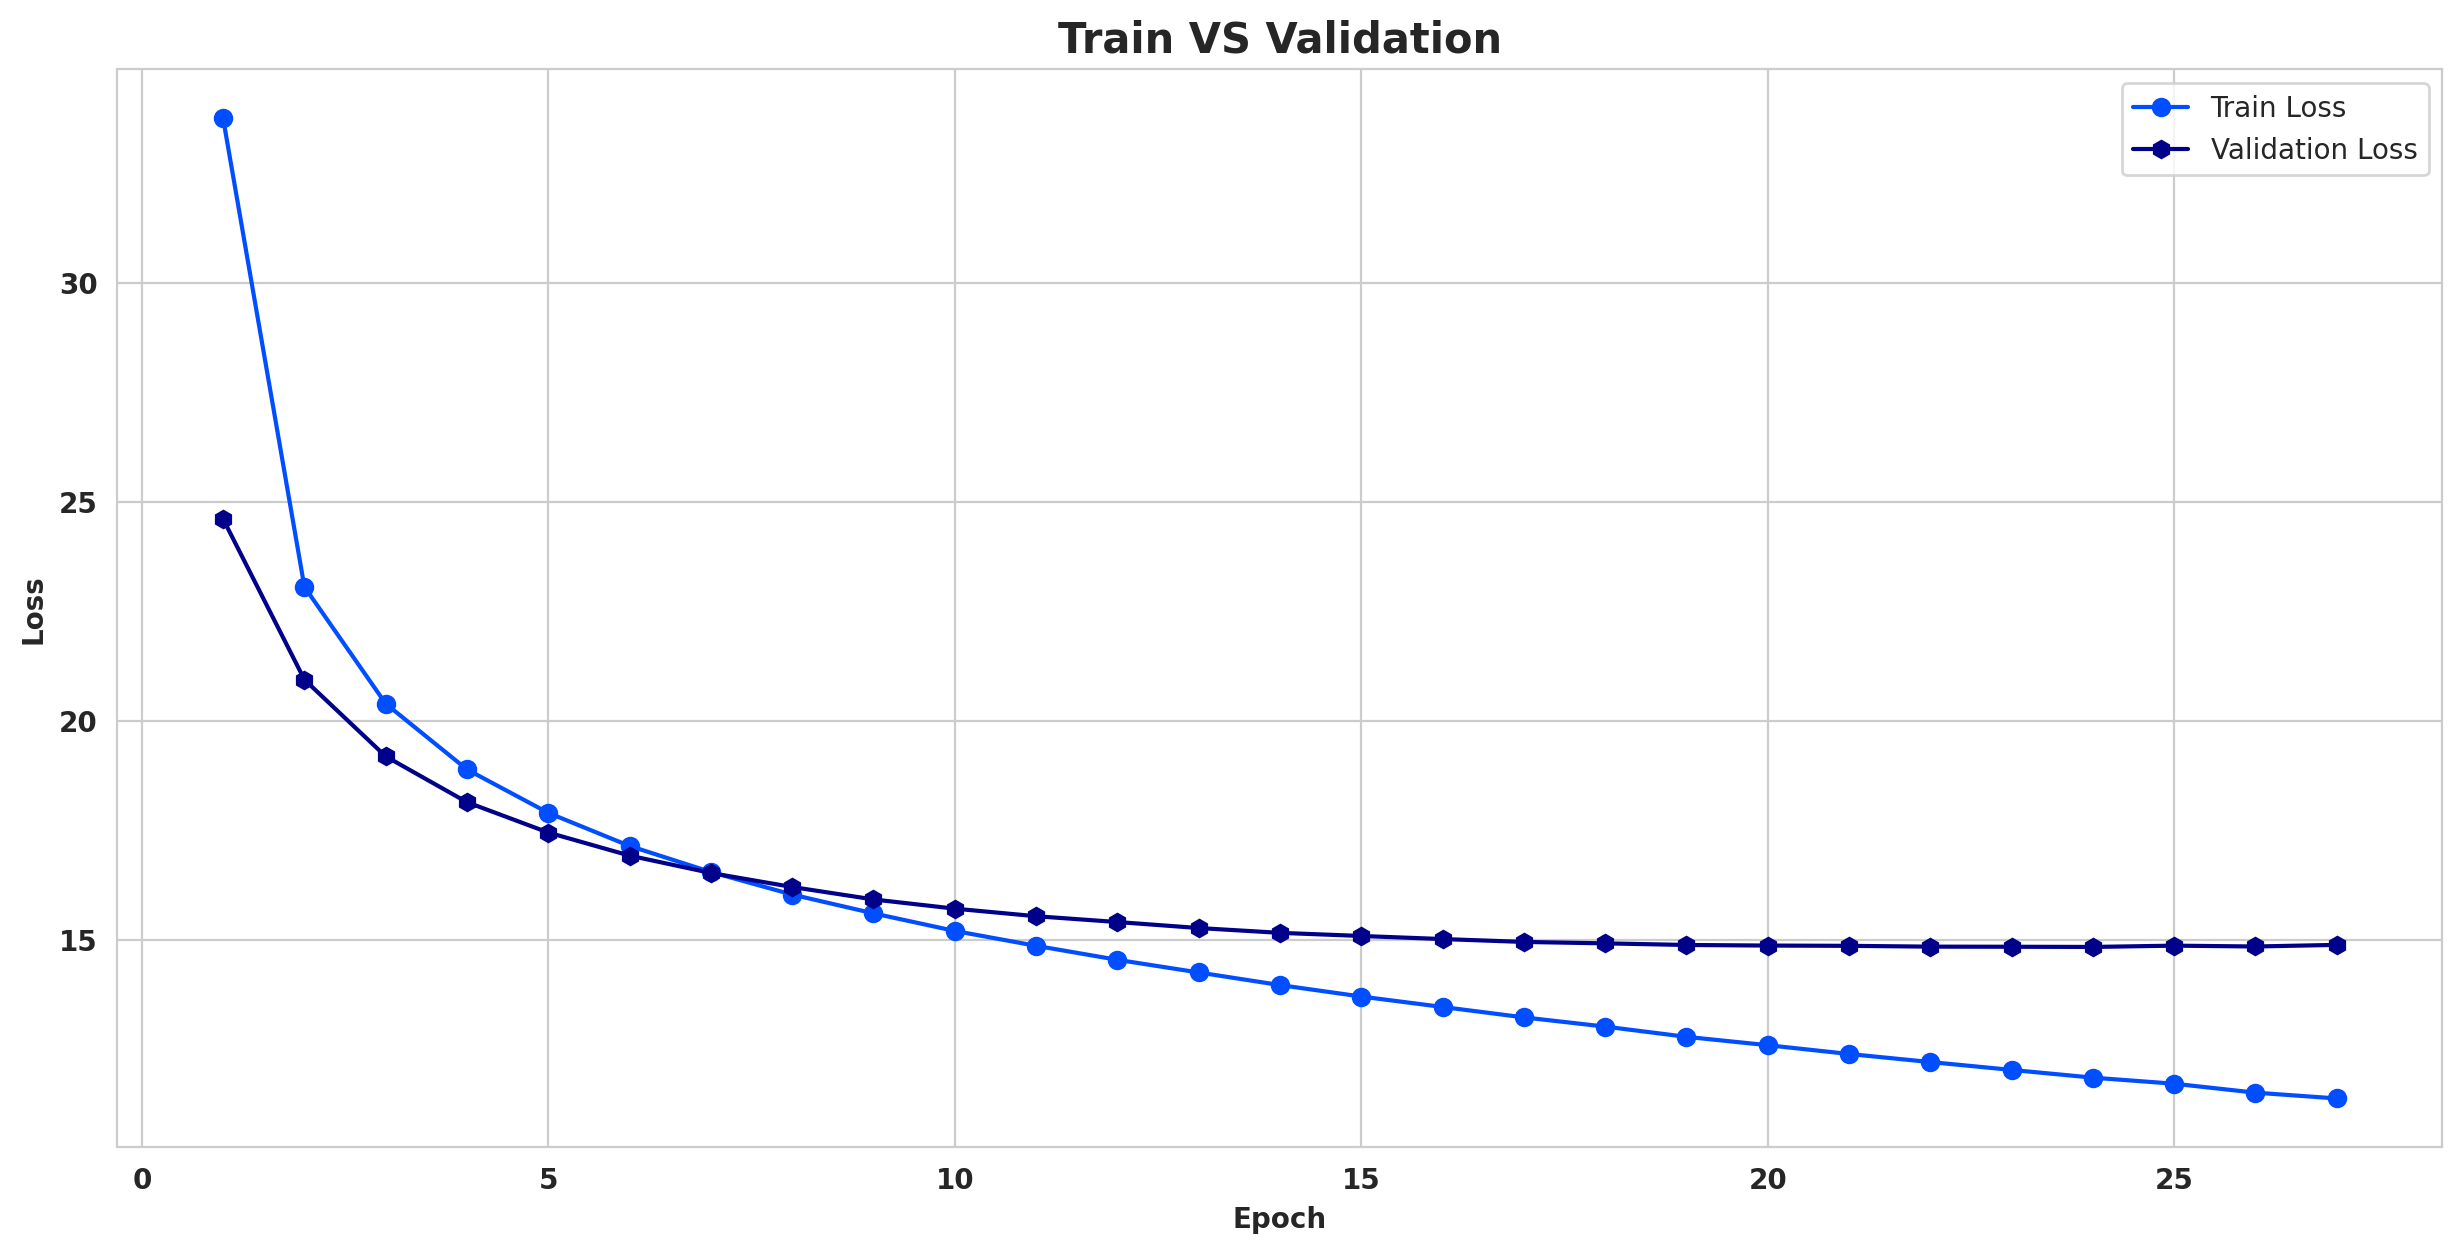

In [15]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#004EFF', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#00008B', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

# Inference
> ##### **Caption Generation:** At **each time step**, **the decoder takes** as input **the embedded image features** along with **the decoded captions** (starting with <start\> at the first time step), **predicting the probabilities** of **the next word**.
> ##### **Greedy algorithm:** To select  **the best caption**, **the greedy algorithm** is employed. This method, chooses **the most probable word** at each time step and **appends it** to the decoded captions **until** the selected word is the **<end\>** token, **or the length** of the decoded captions exceeds  **the maximum sequence length**.
> ##### **Evaluation** is performed using the **BLEU score**
> ##### **Visualization:** The function visualization() plots the **images along with their corresponding actual and predicted captions, accompanied by 4 BLEU scores**.

In [16]:
vocab = vectorization.get_vocabulary()
INDEX_TO_WORD = {idx: word for idx, word in enumerate(vocab)}
MAX_DECODED_SENTENCE_LENGTH = SEQ_LENGTH - 1
test_images = list(test_data.keys())

def greedy_algorithm(image):
    # Read the image from the disk
    image = decode_and_resize(image)

    # Pass the image to the CNN
    image = tf.expand_dims(image, 0)
    image = caption_model.cnn_model(image)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(image, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = INDEX_TO_WORD[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    
    return decoded_caption

In [17]:
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_data), position=0, leave=True, colour='green')
for image_id in test_data:
    cap = greedy_algorithm(image_id)
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

  0%|          | 0/77 [00:00<?, ?it/s]

In [18]:
import json

# Calculates BLEU score of predictions and saves them
def BLEU_score(actual, predicted, save_path="bleu_scores.json"):
    # Standardizing the actual captions
    processed_actual = []
    for i in actual:
        cap = [INDEX_TO_WORD[x] for x in vectorization(i).numpy() if INDEX_TO_WORD[x] != '']
        cap = ' '.join(cap)
        processed_actual.append(cap)
    
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    b1 = corpus_bleu(processed_actual, predicted, weights=(1.0, 0, 0, 0))
    b2 = corpus_bleu(processed_actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3 = corpus_bleu(processed_actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4 = corpus_bleu(processed_actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    # Save BLEU scores to a JSON file
    bleu_scores = {
        "BLEU-1": round(b1, 5),
        "BLEU-2": round(b2, 5),
        "BLEU-3": round(b3, 5),
        "BLEU-4": round(b4, 5),
        "Generated Caption": predicted[0]
    }

    with open(save_path, "w") as f:
        json.dump(bleu_scores, f, indent=4)

    return [
        (f'BLEU-4: {round(b4, 5)}'),
        (f'BLEU-3: {round(b3, 5)}'),
        (f'BLEU-2: {round(b2, 5)}'),
        (f'BLEU-1: {round(b1, 5)}'),
        (f'Generated Caption: {predicted[0]}'),
    ]


### Visualizing some of the **test images** along with their corresponding **generated captions**

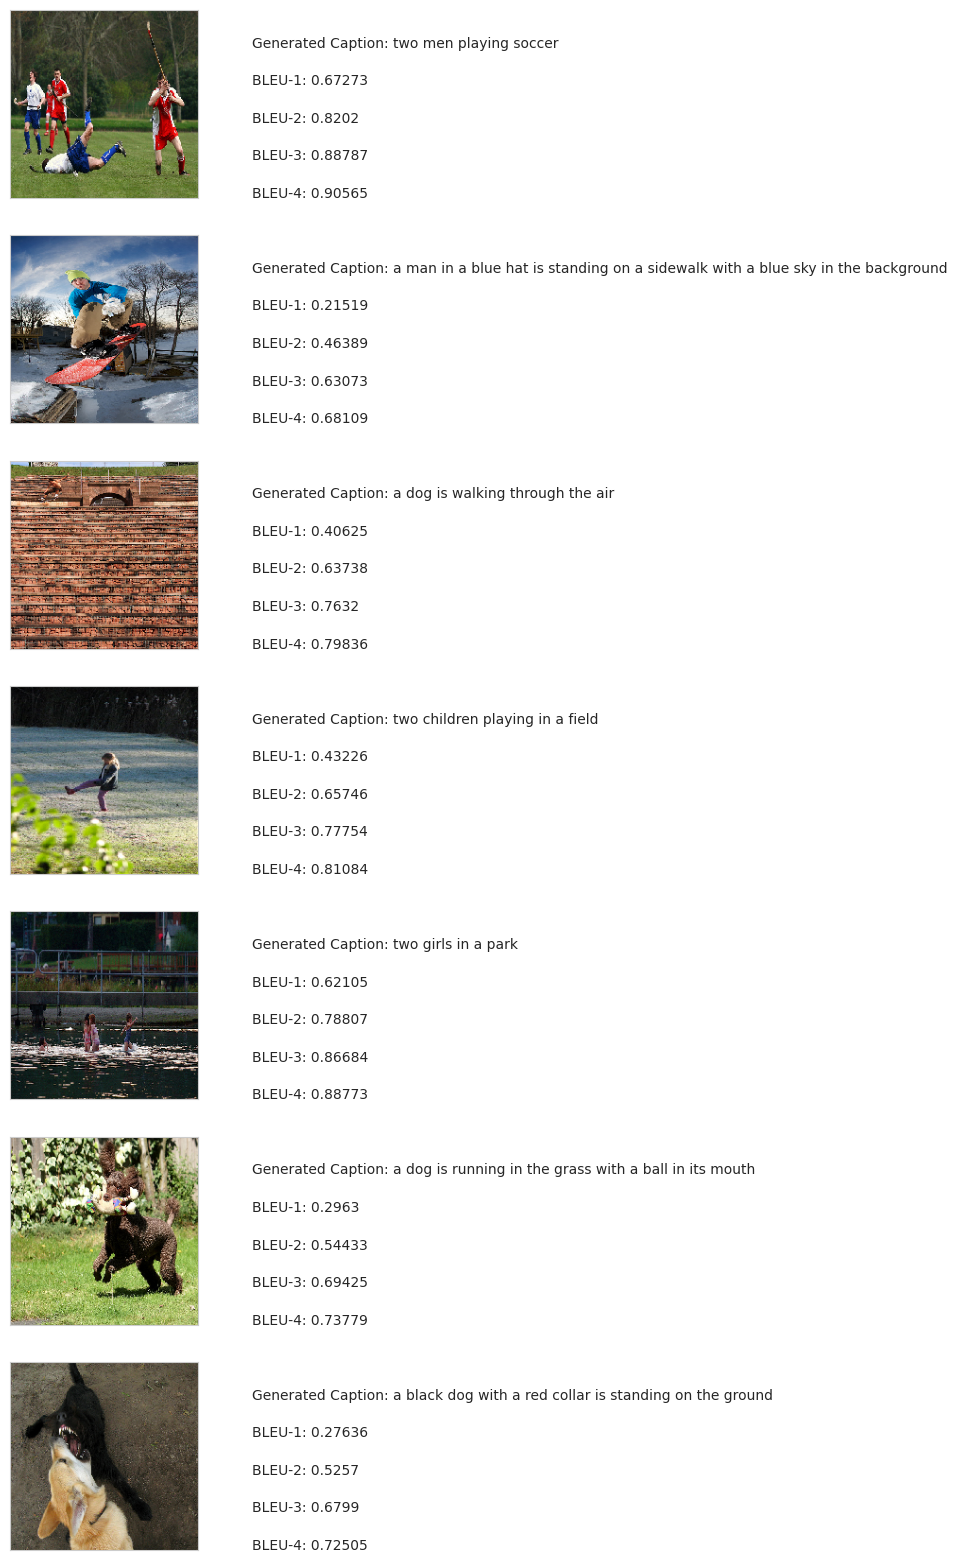

In [19]:
def visualization(data, generated_captions, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("<start> ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" <end>", "") for x in actual_cap] # Removing the end token
        
        caption = generated_captions[filename]
        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [caption]*(len(actual_cap)))
    
        image_load = load_img(filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()
    
visualization(test_data, generated_captions, BLEU_score, 7)

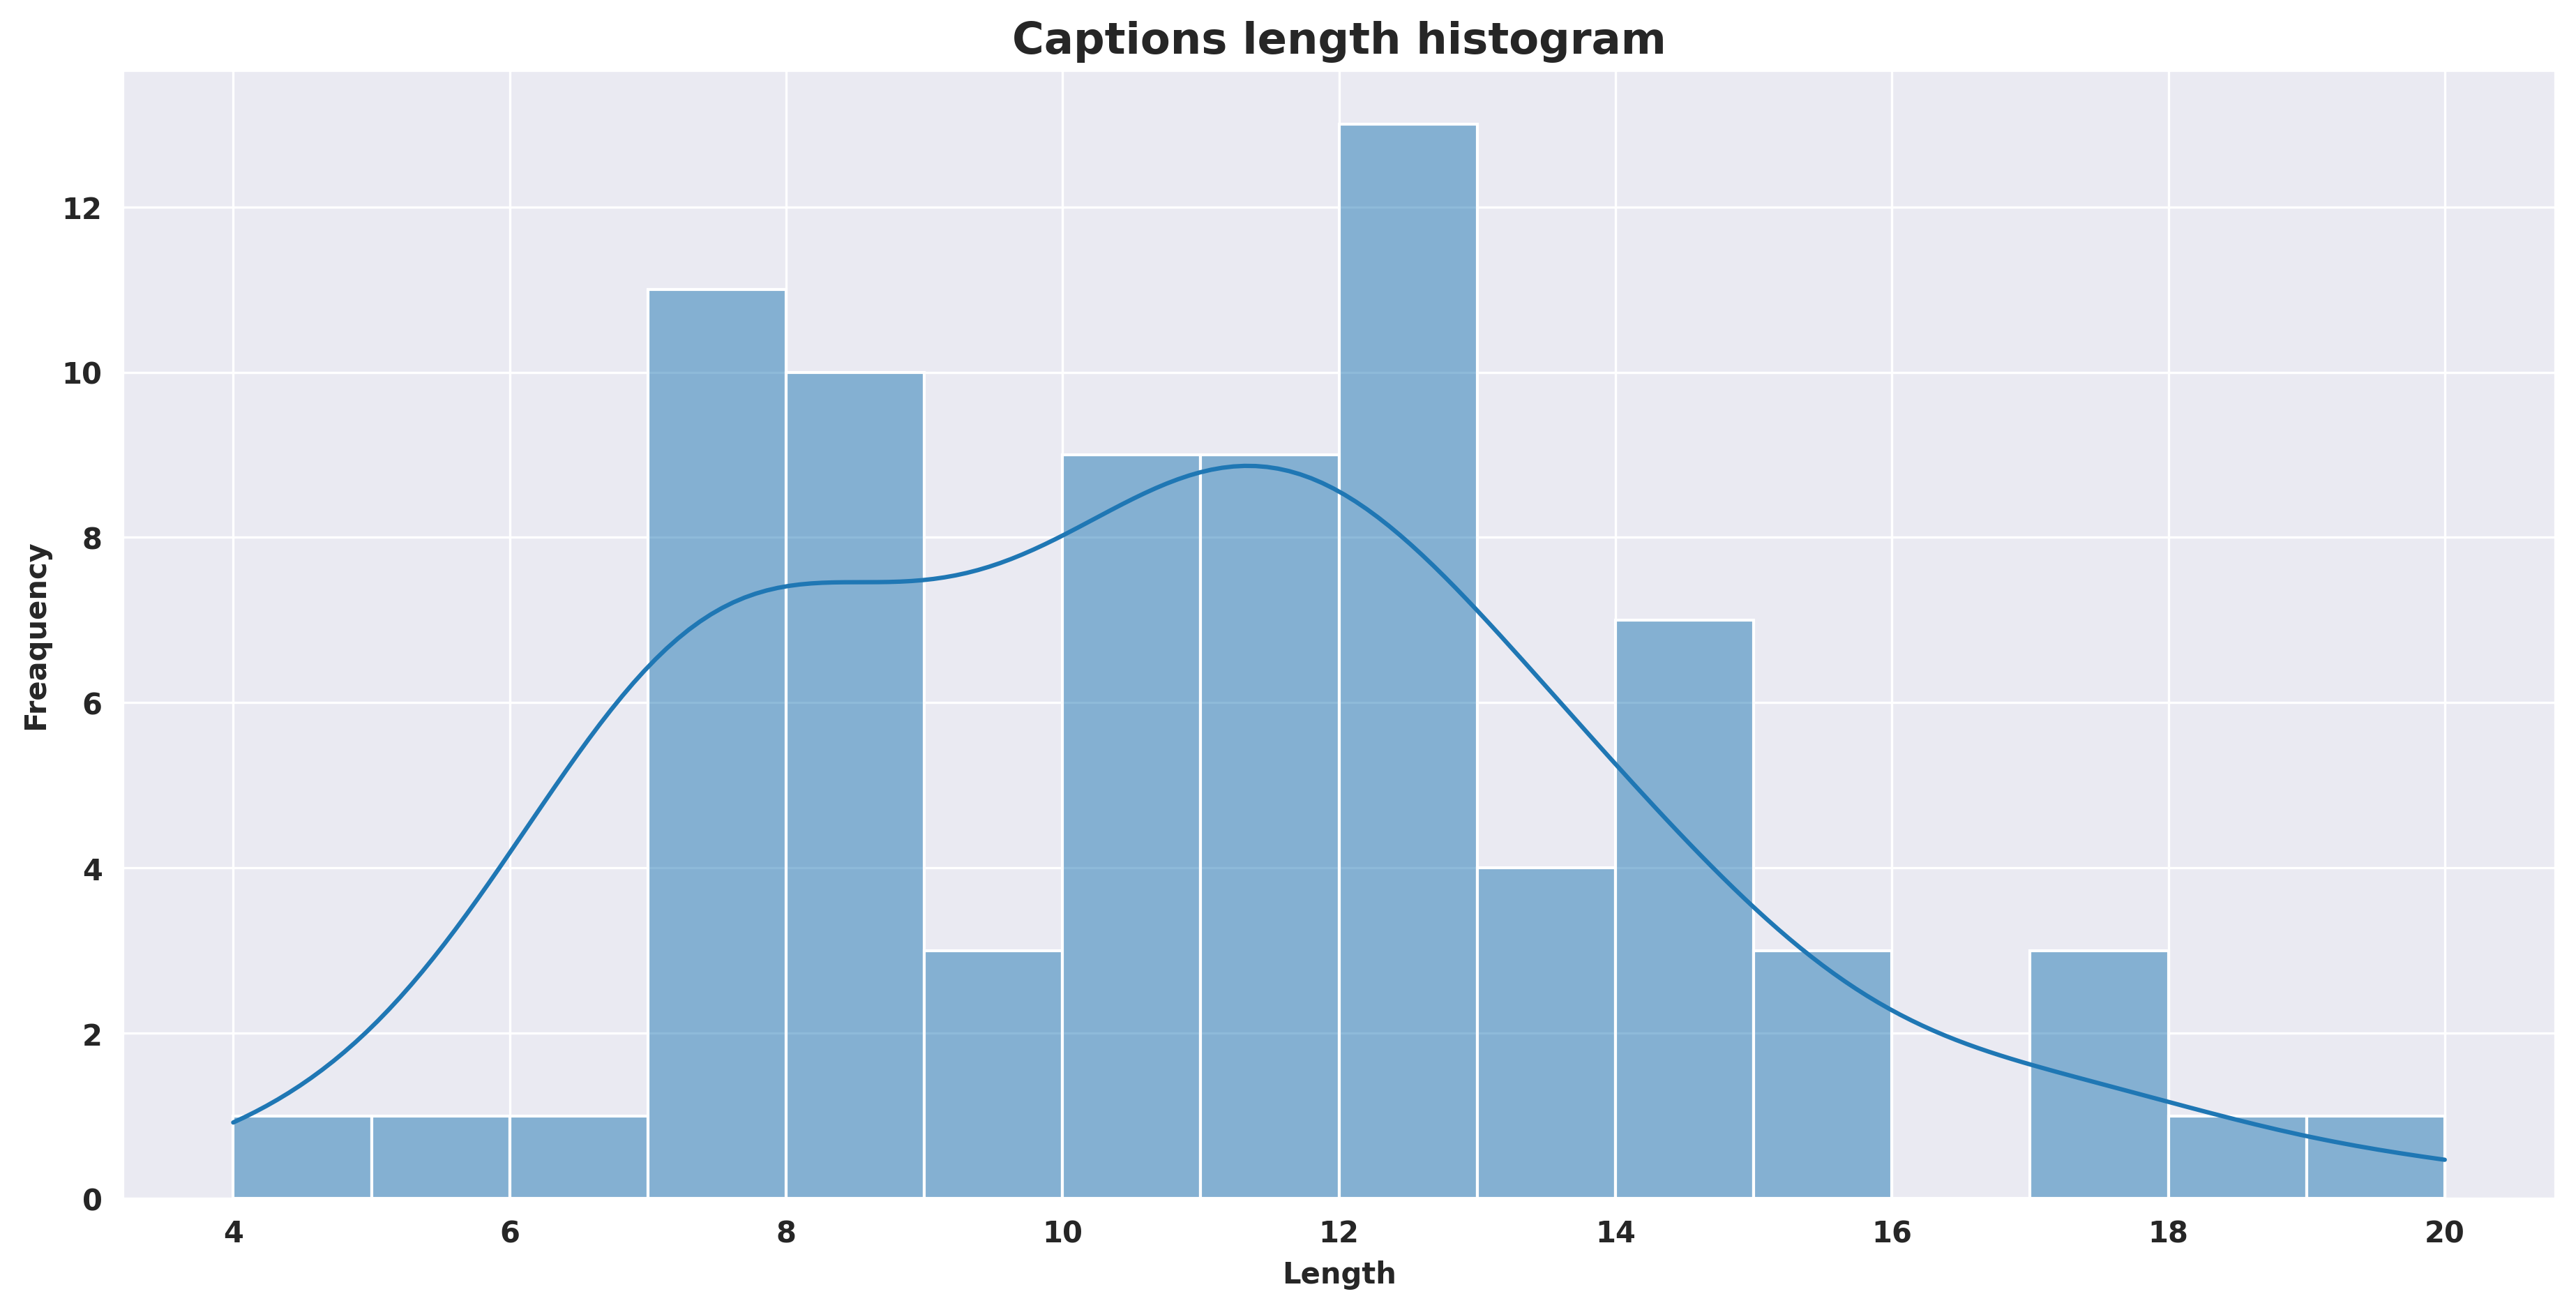

In [20]:
captions_length(list(generated_captions.values()))

In [21]:
word_occurrences(list(generated_captions.values()))

In [22]:
image_path = "/kaggle/input/flickr8k/Images"

In [23]:
import os
import json
import pickle
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


# ✅ Compute BLEU scores using greedy decoding
def compute_bleu_with_greedy(test_data, image_path, caption_model, vectorization, save_path="bleu_scores.json"):
    references = []
    hypotheses = []

    # Process test images
    test_images = list(test_data.keys())
    for image_name in tqdm(test_images, desc="Generating Captions"):
        img_path = os.path.join(image_path, image_name)

        if not os.path.exists(img_path):
            print(f"Warning: Image not found: {img_path}, skipping.")
            continue
        
        # ✅ Generate caption using greedy decoding
        generated_caption = greedy_algorithm(img_path)
        hypotheses.append(generated_caption.split())

        # ✅ Get reference captions
        refs = test_data[image_name]
        processed_refs = [ref.replace("<start>", "").replace("<end>", "").strip().split() for ref in refs]
        references.append(processed_refs)

    # ✅ Save references for later evaluation
    with open("references.pkl", "wb") as f:
        pickle.dump(references, f)

    # ✅ Compute BLEU scores with smoothing
    smoothie = SmoothingFunction().method5
    bleu_scores = {
        "BLEU-1": round(corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie), 5),
        "BLEU-2": round(corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie), 5),
        "BLEU-3": round(corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie), 5),
        "BLEU-4": round(corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie), 5)
    }

    # ✅ Save BLEU scores to a JSON file
    with open(save_path, "w") as json_file:
        json.dump(bleu_scores, json_file, indent=4)

    print(f"BLEU scores saved to {save_path}")
    return bleu_scores


# Run the BLEU score computation and save the results
bleu_scores = compute_bleu_with_greedy(test_data, image_path, caption_model, vectorization, save_path="bleu_scores.json")

# Print BLEU scores
print(json.dumps(bleu_scores, indent=4))

Generating Captions: 100%|██████████| 77/77 [00:58<00:00,  1.33it/s]

BLEU scores saved to bleu_scores.json
{
    "BLEU-1": 0.78895,
    "BLEU-2": 0.54717,
    "BLEU-3": 0.38227,
    "BLEU-4": 0.25515
}
